# Inference code for LongRecon

In [11]:
# import necessary libraries
import os
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

import torch

from model.longitudinal_recon import LongRecon
from params import ModelConfig

In [12]:
# load checkpoint
checkpoint_path = Path("C:/Users/user/Downloads/recon_3d_inftest/log/log_recon_250812/")
checkpoint_list = sorted(checkpoint_path.glob("*.ckpt"))
print(f"Found {len(list(checkpoint_list))} checkpoints in {checkpoint_path}")

Found 1 checkpoints in C:\Users\user\Downloads\recon_3d_inftest\log\log_recon_250812


In [13]:
# load model
idx = 0
checkpoint = torch.load((checkpoint_list[idx]), map_location=torch.device('cpu'))
config = ModelConfig(**checkpoint['model_config'])
model = LongRecon(device=torch.device('cpu'), modelconfig=config)
sd = checkpoint['model_state_dict']
sd = {k.replace('module.', ''): v for k, v in sd.items() if 'module.' in k}
model.load_state_dict(sd)
print(f"Loaded {idx} checkpoint, model ready.")

Loaded 0 checkpoint, model ready.


In [14]:
# load data
data_path = Path("D:/data/slabs")
data_list = sorted(data_path.glob("*.mat"))
print(f"Found {len(list(data_list))} data files in {data_path}")
# data = loadmat(random.choice(data_list))
data = loadmat(data_list[10])  # for testing, use the first file

Found 10781 data files in D:\data\slabs


In [15]:
# prepare input data
prior = torch.Tensor(data['img1_reg']).unsqueeze(0)
prior_rot = torch.Tensor(data['img1']).unsqueeze(0)  # can change it to data['img1'] if needed
target = torch.Tensor(data['img2'])
target = torch.stack((target, torch.zeros_like(target)), dim=-1).unsqueeze(0)
meta = torch.zeros(1,5)

# print shapes
print(f"prior shape: {prior.shape}")
print(f"prior_rot shape: {prior_rot.shape}")
print(f"target shape: {target.shape}")
print(f"meta shape: {meta.shape}")

prior shape: torch.Size([1, 16, 256, 256])
prior_rot shape: torch.Size([1, 16, 256, 256])
target shape: torch.Size([1, 16, 256, 256, 2])
meta shape: torch.Size([1, 5])


In [16]:
# inference
result, label_undersampled, mask, _, sudo_recon, prior_reg = model.long_recon(
    prior=prior,
    prior_rot=prior_rot,
    target=target,
    meta=meta,
)
result2, label_undersampled2, mask2, _, sudo_recon2, prior_reg2 = model.long_recon(
    prior=prior,
    prior_rot=prior_rot,
    target=target,
    meta=meta,
    debug=True,  # for debugging purposes
)

print(f"Result shape: {result.shape}") # [1, 2, 16, 256, 256]
print(f"Label undersampled shape: {label_undersampled.shape}") # [1, 16, 256, 256, 2]
print(f"Mask shape: {mask.shape}") # [1, 1, 256, 256]
print(f"Sudo recon shape: {sudo_recon.shape}") # [1, 1, 16, 256, 256]

result = torch.abs(
        (result[:, 0, :, :, :] + 1j * result[:, 1, :, :, :])
    )
print(f"Result absolute shape: {result.shape}") # [1, 16, 256, 256]
result2 = torch.abs(
        (result2[:, 0, :, :, :] + 1j * result2[:, 1, :, :, :])
    )

z_index = 0

2025-08-13 15:34:24 [TRACE] Diffusion time : 1000
2025-08-13 15:34:28 [TRACE] Diffusion time : 800
2025-08-13 15:34:33 [TRACE] Diffusion time : 600
2025-08-13 15:34:38 [TRACE] Diffusion time : 400
2025-08-13 15:34:42 [TRACE] Diffusion time : 300
2025-08-13 15:34:47 [TRACE] Diffusion time : 200
2025-08-13 15:34:52 [TRACE] Diffusion time : 150
2025-08-13 15:34:56 [TRACE] Diffusion time : 100
2025-08-13 15:35:00 [TRACE] Diffusion time : 50
2025-08-13 15:35:13 [TRACE] Diffusion time : 1000
Result shape: torch.Size([1, 2, 16, 256, 256])
Label undersampled shape: torch.Size([1, 16, 256, 256, 2])
Mask shape: torch.Size([1, 1, 256, 256])
Sudo recon shape: torch.Size([1, 1, 16, 256, 256])
Result absolute shape: torch.Size([1, 16, 256, 256])


Text(0.5, 1.0, 'Undersampled Label')

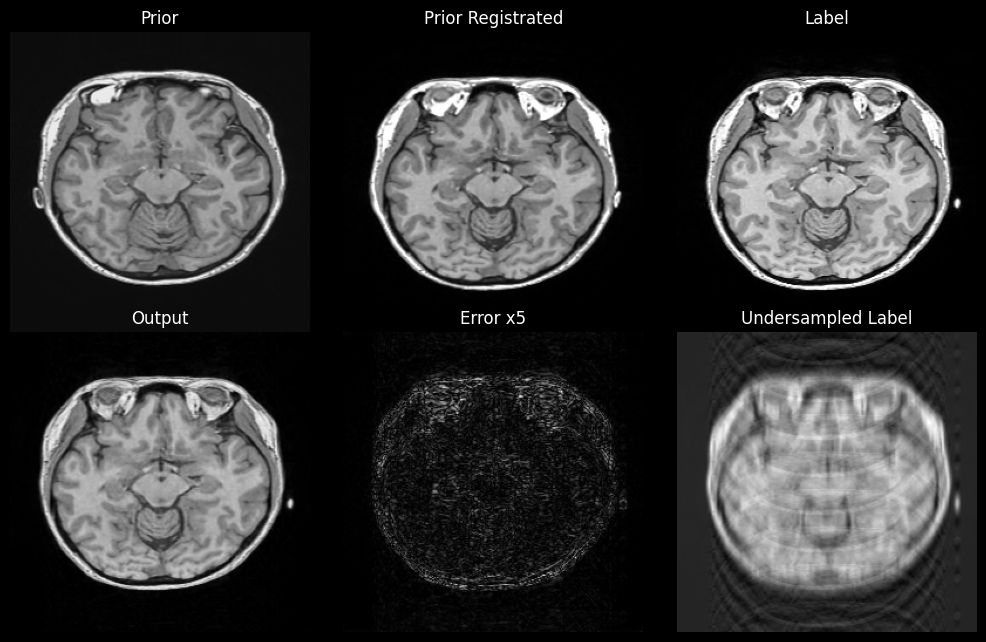

In [17]:
z_index+=1  # slice index to visualize

prior_img        = prior.squeeze(0)[z_index].detach().cpu().numpy()                     # [Z,H,W]
prior_rot_img    = prior_rot.squeeze(0)[z_index].detach().cpu().numpy()                 # [Z,H,W]
prior_reg_img    = prior_reg.squeeze()[z_index].detach().cpu().numpy()                 # [Z,H,W]
recon_img        = result.squeeze(0)[z_index].detach().cpu().numpy()                 # [2,Z,H,W] -> real
label_img        = target.squeeze(0)[z_index, :, :, 0].detach().cpu().numpy()           # [Z,H,W,2] -> real
label_us_img     = label_undersampled.squeeze(0)[z_index, :, :, 0].detach().cpu().numpy()  # [Z,H,W,2] -> real
mask_img         = mask.squeeze(0).squeeze(0).detach().cpu().numpy()                    # [H,W]
sudo_recon_img   = sudo_recon.squeeze(0).squeeze(0)[z_index].detach().cpu().numpy()     # [Z,H,W]


prior_img, prior_rot_img, prior_reg_img, recon_img, label_img, label_us_img, mask_img, sudo_recon_img 

fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
fig.patch.set_facecolor("black")

plt.subplot(2, 3, 1)
plt.imshow(np.rot90(prior_reg_img), cmap="gray")
plt.axis("off")
plt.title("Prior", color="white")

plt.subplot(2, 3, 2)
plt.imshow(np.rot90(prior_img), cmap="gray")
plt.axis("off")
plt.title("Prior Registrated", color="white")

plt.subplot(2, 3, 3)
plt.imshow(np.rot90(label_img), cmap="gray")
plt.axis("off")
plt.title("Label", color="white")

plt.subplot(2, 3, 4)
plt.imshow(np.rot90(recon_img), cmap="gray")
plt.axis("off")
plt.title("Output", color="white")

plt.subplot(2, 3, 5)
plt.imshow(np.rot90( abs(label_img - recon_img)), cmap="gray")
plt.axis("off")
plt.title("Error x5", color="white")

plt.subplot(2, 3, 6)
plt.imshow(np.rot90(label_us_img), cmap="gray")
plt.axis("off")
plt.title("Undersampled Label", color="white")


In [18]:
from common.metric import calculate_psnr, calculate_ssim

metric_recon_img = result
metric_recon_img2 = result2
metric_label_img = target[:, :, :, :, 0]

psnr = calculate_psnr(metric_recon_img, metric_label_img)
ssim = calculate_ssim(metric_recon_img, metric_label_img)

psnr2 = calculate_psnr(metric_recon_img2, metric_label_img)
ssim2 = calculate_ssim(metric_recon_img2, metric_label_img)

print(f"PSNR: {float(psnr):.2f}, SSIM: {float(ssim):.4f}")
print(f"PSNR2: {float(psnr2):.2f}, SSIM2: {float(ssim2):.4f}")


PSNR: 29.22, SSIM: 0.8897
PSNR2: 29.08, SSIM2: 0.8855


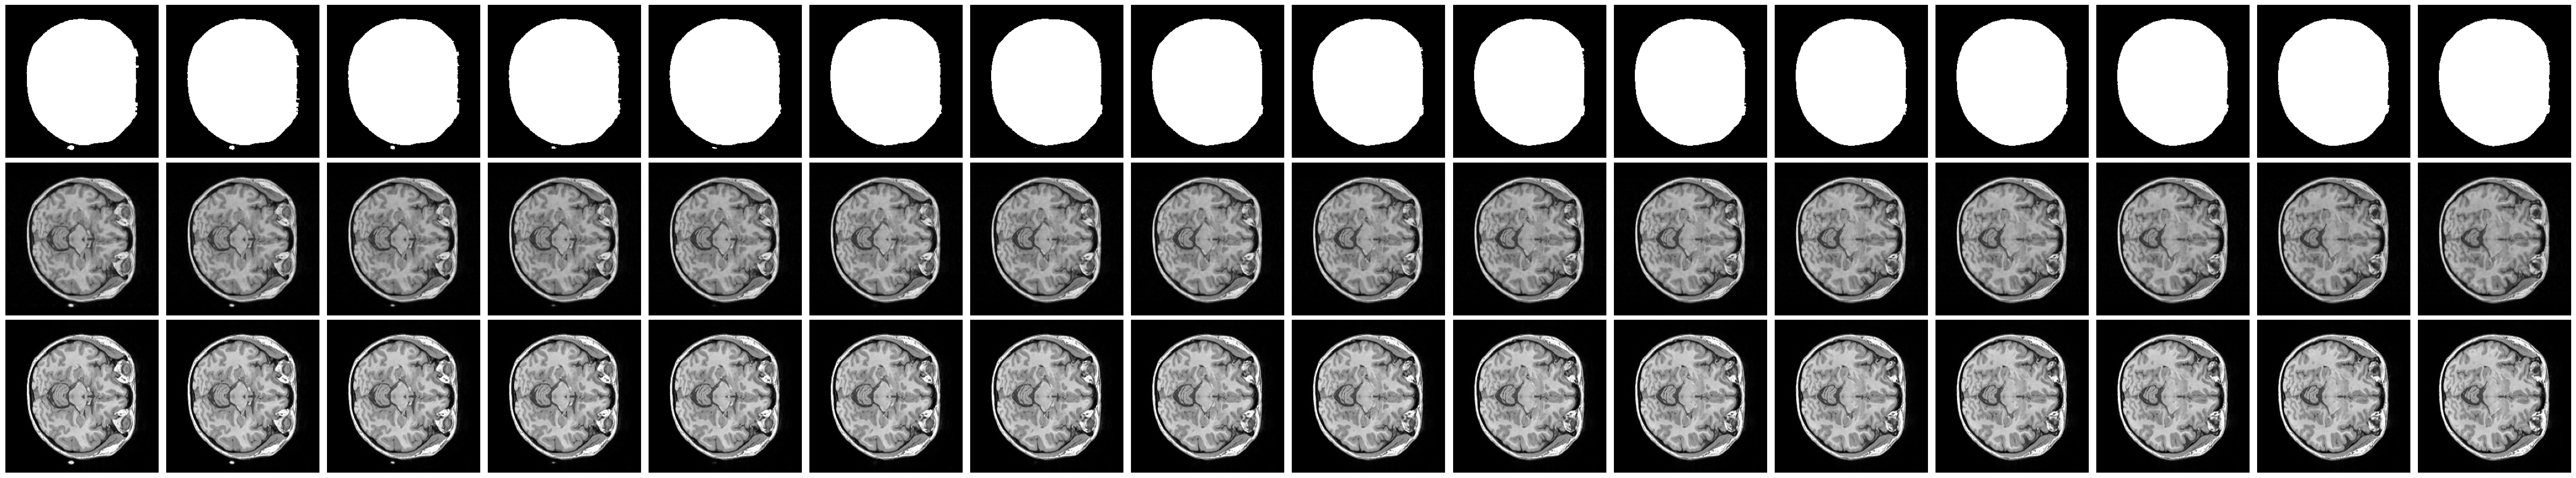

PSNR: 26.37, SSIM: 0.9300


In [19]:
def continuous_brain_mask(img, thr=0.1):
    mask = np.zeros_like(img, dtype=np.uint8)
    for i in range(img.shape[0]):
        row = img[i]
        idx = np.where(row > thr * img.max())[0]
        if idx.size > 0:
            mask[i, idx.min():idx.max()+1] = 1
    return mask

masks = []
for i in range(metric_label_img.shape[1]):
    masks.append(continuous_brain_mask(metric_label_img[0, i,:,:], thr=0.1))

# plot each masks
plt.figure(figsize=(3 * len(masks), 9))
for i, mask in enumerate(masks):
    plt.subplot(3, len(masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
for i in range(len(masks)):
    plt.subplot(3, len(masks), len(masks) + i + 1)
    plt.imshow(metric_recon_img[0, i, :, :], cmap='gray')
    plt.axis('off')
for i in range(len(masks)):
    plt.subplot(3, len(masks), 2 * len(masks) + i + 1)
    plt.imshow(metric_label_img[0, i, :, :], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

mask = torch.Tensor(masks).unsqueeze(0)

psnr = calculate_psnr(metric_recon_img, metric_label_img, mask)
ssim = calculate_ssim(metric_recon_img, metric_label_img, mask)
f = ratio = (mask == 1).float().mean().item()
ssim = (ssim - (1-f))/f

print(f"PSNR: {float(psnr):.2f}, SSIM: {float(ssim):.4f}")

TypeError: Invalid shape (16, 256, 256) for image data

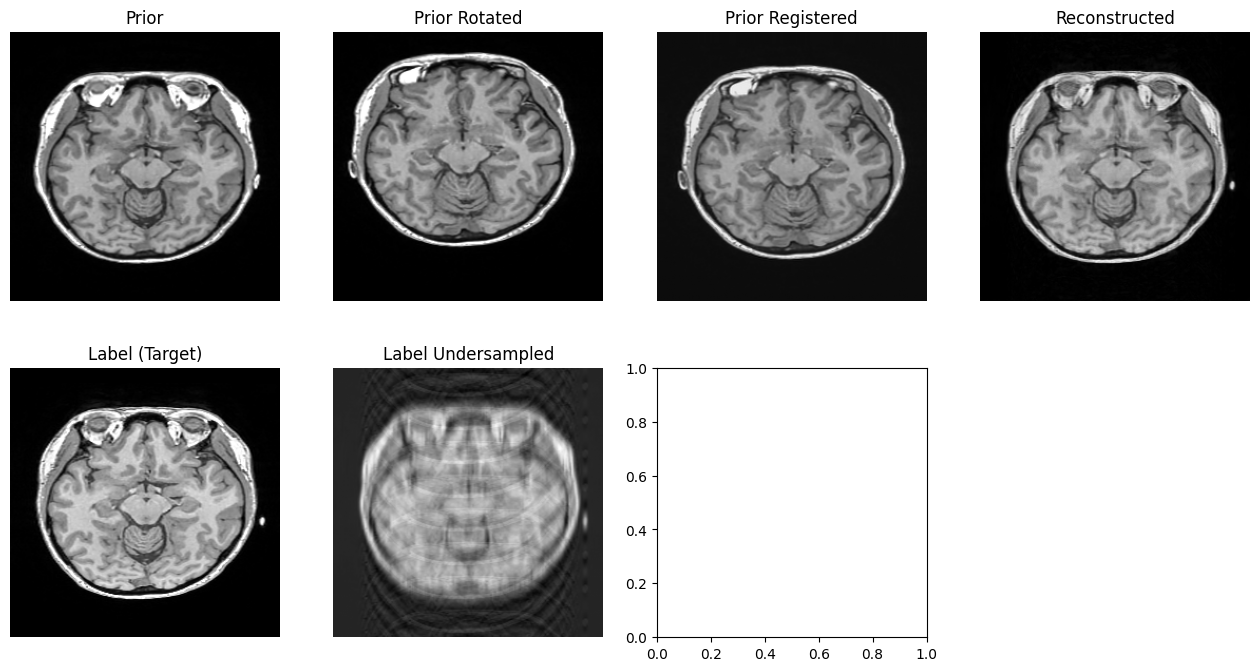

In [20]:
z_index+=0  # slice index to visualize

prior_img        = prior.squeeze(0)[z_index].detach().cpu().numpy()                     # [Z,H,W]
prior_rot_img    = prior_rot.squeeze(0)[z_index].detach().cpu().numpy()                 # [Z,H,W]
prior_reg_img    = prior_reg.squeeze()[z_index].detach().cpu().numpy()                 # [Z,H,W]
recon_img2        = result2.squeeze(0)[z_index].detach().cpu().numpy()                 # [2,Z,H,W] -> real
label_img        = target.squeeze(0)[z_index, :, :, 0].detach().cpu().numpy()           # [Z,H,W,2] -> real
label_us_img     = label_undersampled.squeeze(0)[z_index, :, :, 0].detach().cpu().numpy()  # [Z,H,W,2] -> real
mask_img         = mask.squeeze(0).squeeze(0).detach().cpu().numpy()                    # [H,W]
sudo_recon_img   = sudo_recon.squeeze(0).squeeze(0)[z_index].detach().cpu().numpy()     # [Z,H,W]

# Plot 2x4 grid
plt.figure(figsize=(16, 8))

plt.subplot(2, 4, 1); plt.imshow(np.rot90(prior_img), cmap='gray');      plt.title('Prior');              plt.axis('off')
plt.subplot(2, 4, 2); plt.imshow(np.rot90(prior_rot_img), cmap='gray');  plt.title('Prior Rotated');      plt.axis('off')
plt.subplot(2, 4, 3); plt.imshow(np.rot90(prior_reg_img), cmap='gray');  plt.title('Prior Registered');   plt.axis('off')
plt.subplot(2, 4, 4); plt.imshow(np.rot90(recon_img2), cmap='gray');      plt.title('Reconstructed');      plt.axis('off')

plt.subplot(2, 4, 5); plt.imshow(np.rot90(label_img), cmap='gray');      plt.title('Label (Target)');     plt.axis('off')
plt.subplot(2, 4, 6); plt.imshow(np.rot90(label_us_img), cmap='gray');   plt.title('Label Undersampled'); plt.axis('off')
plt.subplot(2, 4, 7); plt.imshow(mask_img, cmap='gray');       plt.title('Mask');               plt.axis('off')
plt.subplot(2, 4, 8); plt.imshow(np.rot90(sudo_recon_img), cmap='gray'); plt.title('Sudo Recon');         plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
loss = torch.nn.functional.mse_loss(
    torch.Tensor(recon_img),
    torch.Tensor(label_img)
)
print(f"Loss: {loss.item()}")  # Print the loss value

loss = torch.nn.functional.mse_loss(
    torch.Tensor(sudo_recon_img),
    torch.Tensor(label_img)
)
print(f"Sudo Recon Loss: {loss.item()}")  # Print the sudo recon loss value

loss2 = torch.nn.functional.mse_loss(
    torch.Tensor(recon_img2),
    torch.Tensor(label_img)
)
print(f"Loss2: {loss2.item()}")  # Print the loss value for the second reconstruction



Loss: 0.0006268376018851995
Sudo Recon Loss: 0.0016631395556032658
Loss2: 0.0006011702353134751
